In [1]:
import TFO_dataset
from math import pi
from sklearn.gaussian_process import *
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp_chunk, get_interpolate_fit_params
from inverse_modelling_tfo.data import normalize_zero_mean 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [2]:
sheep_id = 36
data = TFO_dataset.SheepData('iq_demod_optical').get(sheep_id)
print(TFO_dataset.SheepData('iq_demod_optical').get_tuple(sheep_id))

(7, 1, 'sp2022')


In [3]:
train_data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_averaged_sim_data.pkl')
train_data['Intensity'] /= 20   # Normalize by the number of detectors per ring

# Make the TMPs zero mean
train_data['Maternal Wall Thickness'] = (train_data['Maternal Wall Thickness'] - 2.0)/32. - 0.5
train_data['Maternal Mu_a'] = (train_data['Maternal Mu_a'] - 0.005)/0.009 - 0.5
train_data['Fetal Mu_a'] = (train_data['Fetal Mu_a'] - 0.05)/0.09 - 0.5


train_data.head()
fitting_param_table = get_interpolate_fit_params(train_data, weights=[1, -3])
fitting_param_table.head()


,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0,alpha1,alpha2,alpha3
0,2.0,6.0,-0.3125,-0.500000,-0.5,0.086606,-17.238918,35.802250,-26.913964
1,2.0,6.0,-0.3125,-0.444444,-0.5,0.100256,-17.788229,36.790623,-27.461771
2,2.0,6.0,-0.3125,-0.388889,-0.5,0.114058,-18.342009,37.787019,-28.014035
3,2.0,6.0,-0.3125,-0.333333,-0.5,0.128025,-18.900636,38.792117,-28.571145
4,2.0,6.0,-0.3125,-0.277778,-0.5,0.142163,-19.464398,39.806440,-29.133394


In [3]:
wv1_params = fitting_param_table[fitting_param_table['Wave Int'] == 1.0]

# Normalize the fitting params
train_X = wv1_params[['alpha0', 'alpha1', 'alpha2', 'alpha3']].to_numpy()
alpha_scaler = preprocessing.StandardScaler().fit(train_X)
train_X = alpha_scaler.transform(train_X)
# Show
print(train_X[:10, :])


# Y is already scaled
train_Y = wv1_params[['Maternal Mu_a']].to_numpy().flatten()


NameError: name 'fitting_param_table' is not defined

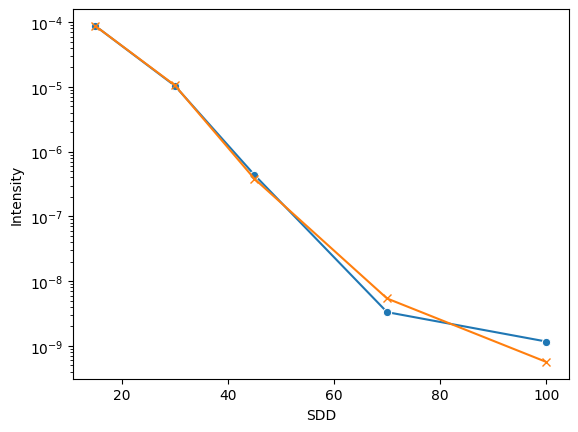

In [4]:
# Pick a point in time
spatial_intensity = data.iloc[600 * 80].copy()  # at 300s with 80Hz sampling freq.
spatial_intensity *=  pi * 4   # from unit area -> pi r^2 area -> match simulation
spatial_intensity *=  1/0.4   # To account for the duty cycle/ taking the first fundemental

# Reshape ppg data to fit the format
SDD = [15, 30, 45, 70, 100]     # For our TFO device, in mm
spatial_intensity_wv1 = pd.DataFrame(data={
    'SDD' : SDD,
    'Intensity' : spatial_intensity.to_numpy()[:5]
})
spatial_intensity_wv2 = pd.DataFrame(data={
    'SDD' : SDD,
    'Intensity' : spatial_intensity.to_numpy()[5:]
})

sns.lineplot(data=spatial_intensity_wv1, x='SDD', y='Intensity', marker='o')

interpolated_data = interpolate_exp_chunk(spatial_intensity_wv1, weights=[1.0, -2.0])
plt.plot(SDD, interpolated_data.flatten(), marker='x')
plt.yscale('log')


In [5]:
alpha_wv1 = interpolate_exp_chunk(spatial_intensity_wv1[:4], weights=[1.0, -2.0], return_alpha=True)
alpha_wv2 = interpolate_exp_chunk(spatial_intensity_wv2[:4], weights=[1.0, -2.0], return_alpha=True)
print(f'NonNormalized alphas for WV1 : {alpha_wv1.flatten()}')
print(f'NonNormalized alphas for WV2 : {alpha_wv2.flatten()}')

# Scale them to match the training data
alpha_wv1 = alpha_scaler.transform(alpha_wv1.reshape(1, -1))
alpha_wv2 = alpha_scaler.transform(alpha_wv2.reshape(1, -1))
print(f'Normalized alphas for WV1 : {alpha_wv1.flatten()}')
print(f'Normalized alphas for WV2 : {alpha_wv2.flatten()}')

NonNormalized alphas for WV1 : [-73.46343773   0.65481226 -43.61864001  90.51654572]
NonNormalized alphas for WV2 : [-90.57423821   0.92216475 -56.77344378 116.74428871]


NameError: name 'alpha_scaler' is not defined

In [10]:
# GPR
reg = GaussianProcessRegressor(kernels.RBF(), alpha=1e-6)
reg.fit(train_X, train_Y)

GaussianProcessRegressor(alpha=1e-06, kernel=RBF(length_scale=1))

In [11]:
estimate, confidence = reg.predict(alpha_wv1, return_std=True)
print(estimate)
print(confidence)

[0.]
[1.]


In [109]:
print(f'alpha means (From training) : {alpha_scaler.mean_}')
print(f'alpha variance (From training) : {alpha_scaler.var_}')

alpha means (From training) : [-8.23467671e-03 -5.94345903e+00  1.17101449e+01 -6.83157796e+00]
alpha variance (From training) : [1.08973567e-01 1.50589950e+02 5.02845214e+02 1.65578999e+02]
